# 图像增广

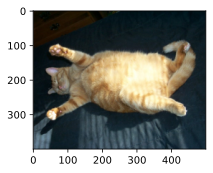

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from Utils import resnet18

d2l.set_figsize()
img = d2l.Image.open('data/img/cat1.jpg')
d2l.plt.imshow(img)

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

## 左右翻转图像

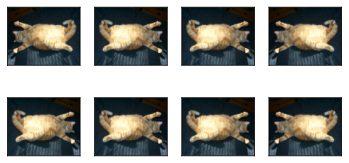

In [3]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

## 上下翻转图像

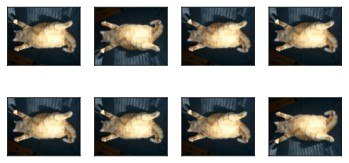

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())

## 随机裁剪

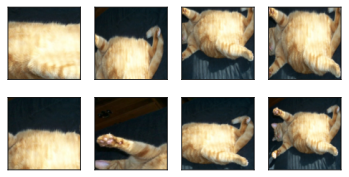

In [5]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

## 随机更改图像的亮度

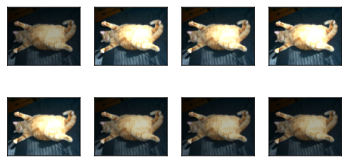

In [6]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

## 随机更改图像色调

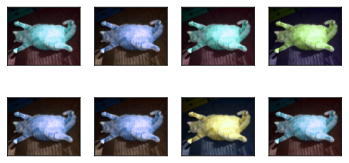

In [7]:
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

## 随机更改图像的亮度(brightness)，对比度(contrast)，饱和(saturation)和色调(hue)

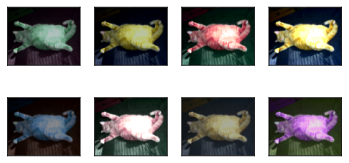

In [8]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

## 结合多种图方法

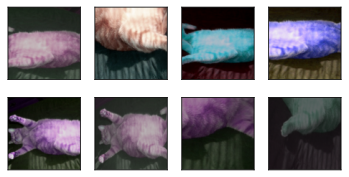

In [9]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug, shape_aug
])
apply(img, augs)

## 使用图像增广进行训练

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

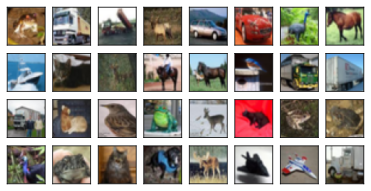

In [10]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root="data/img", download=True
)
d2l.show_images([
    all_images[i][0] for i in range(32) ], 4, 8, scale=0.8)

### 只使用最简单的随机左右翻转

In [11]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

### 定义一个辅助函数，以便于读取图像和应用图像增广

In [12]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="data/img", train=is_train,
        transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=4)
    return dataloader

### 定义一个函数，使用多GPU对模型进行训练和评估

In [13]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backwards()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                           legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net,features,labels,loss,trainer,devices)   
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))              
        test_acc = d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc'
         f' {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f' {metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
         f' {str(devices)}')  

### 定义train_with_data_aug函数，使用图像增广来训练模型

In [14]:
batch_size, devices, net = 256, d2l.try_all_gpus(), resnet18(10)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[256, 3, 32, 32] to have 1 channels, but got 3 channels instead

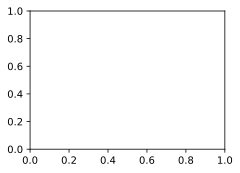

In [15]:
train_with_data_aug(train_augs, test_augs, net)

In [ ]:
train_with_data_aug(test_augs, test_augs, net)